In [66]:
%pip install gymnasium stable-baselines3 shimmy yfinance pandas numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

In [68]:
# 1. Define Tickers
tickers = ['BBAI', 'SOFI', 'AIPO', 'MSFT', 'NVO', 'ZS', 'SMCI', 'CRWV', 'AMZN', 'MU', 'AAPL', 'META', 'AMD', 'VOO', 'TSM', 'GOOGL', 'NVDA']

# 2. Download Data
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(f"Downloading data from {start_date.date()} to {end_date.date()}")

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# 3. Clean Data
if isinstance(data.columns, pd.MultiIndex):
    try:
        adjusted_close_prices = data['Adj Close']
    except KeyError:
        adjusted_close_prices = data['Close']
else:
    adjusted_close_prices = data

# Drop empty columns, keep all rows (even with missing data)
adjusted_close_prices.dropna(axis=1, how='all', inplace=True)
tickers = adjusted_close_prices.columns.tolist()

print(f"Final Ticker List: {tickers}")

[*********************100%***********************]  17 of 17 completed

Final Ticker List: ['AAPL', 'AIPO', 'AMD', 'AMZN', 'BBAI', 'CRWV', 'GOOGL', 'META', 'MSFT', 'MU', 'NVDA', 'NVO', 'SMCI', 'SOFI', 'TSM', 'VOO', 'ZS']



/var/folders/7h/8_hzlm9513b1s11m2xjwcnvm0000gn/T/ipykernel_52606/1089241003.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_close_prices.dropna(axis=1, how='all', inplace=True)


In [69]:
# 1. Calculate Log Returns
log_returns = np.log(adjusted_close_prices / adjusted_close_prices.shift(1))

# 2. RSI Helper
def calculate_rsi(data, window=14):
    delta = data.diff()
    delta.fillna(0, inplace=True)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rs.replace([np.inf, -np.inf], 0, inplace=True)
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50)

# 3. Calculate "Excess Returns" (Relative Strength)
# This tells the AI how much a stock beat the daily average
# If Stock=+1% and Market=+1%, Excess=0%. The AI learns to ignore "market noise."
market_mean = log_returns.mean(axis=1)
excess_data = log_returns.subtract(market_mean, axis=0)

# 4. Generate RSI
rsi_data = calculate_rsi(adjusted_close_prices)

# 5. Clean Data (Aggressive)
# Fix NaNs/Infs
log_returns.replace([np.inf, -np.inf], 0, inplace=True)
log_returns.fillna(0, inplace=True)

rsi_data.replace([np.inf, -np.inf], 50, inplace=True)
rsi_data.fillna(50, inplace=True)

excess_data.replace([np.inf, -np.inf], 0, inplace=True)
excess_data.fillna(0, inplace=True)

# 6. Align Data
valid_start = 30
log_returns = log_returns.iloc[valid_start:]
rsi_data = rsi_data.iloc[valid_start:]
excess_data = excess_data.iloc[valid_start:] # <--- NEW

print(f"Data Shape: {log_returns.shape}")

Data Shape: (1224, 17)


In [70]:
class PortfolioEnv(gym.Env):
    def __init__(self, returns_data, rsi_data, excess_data, window_size=30, trading_cost=0.0):
        super(PortfolioEnv, self).__init__()

        self.df = returns_data
        self.rsi = rsi_data
        self.excess = excess_data # <--- NEW
        self.n_assets = len(returns_data.columns)
        self.window_size = window_size
        self.trading_cost = trading_cost

        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.n_assets,), dtype=np.float32)

        # Observation: Returns + RSI + Excess + Weights
        self.observation_space = gym.spaces.Dict({
            "returns": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, self.n_assets), dtype=np.float32),
            "rsi": gym.spaces.Box(low=0, high=100, shape=(window_size, self.n_assets), dtype=np.float32),
            "excess": gym.spaces.Box(low=-np.inf, high=np.inf, shape=(window_size, self.n_assets), dtype=np.float32), # <--- NEW
            "weights": gym.spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        })

        self.current_step = self.window_size
        self.current_weights = np.ones(self.n_assets) / self.n_assets

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.current_weights = np.ones(self.n_assets) / self.n_assets
        
        obs = {
            "returns": self.df.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "rsi": self.rsi.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "excess": self.excess.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "weights": self.current_weights.astype(np.float32)
        }
        return obs, {}

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def step(self, action):
        target_weights = self.softmax(action)
        
        if self.current_step >= len(self.df) - 1:
            zero = np.zeros((self.window_size, self.n_assets), dtype=np.float32)
            # Return zero-filled dict to prevent crash
            return {"returns": zero, "rsi": zero, "excess": zero, "weights": self.current_weights.astype(np.float32)}, 0, True, False, {}
        
        # Costs
        trade_amount = np.sum(np.abs(target_weights - self.current_weights))
        cost = trade_amount * self.trading_cost
        
        # Returns
        next_day_returns = self.df.iloc[self.current_step].values
        portfolio_return = np.sum(target_weights * next_day_returns) - cost
        
        # Benchmark
        benchmark_return = np.mean(next_day_returns)
        
        # Reward = Alpha
        alpha = portfolio_return - benchmark_return
        reward = alpha * 100
        
        self.current_weights = target_weights 
        self.current_step += 1
        
        obs = {
            "returns": self.df.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "rsi": self.rsi.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "excess": self.excess.iloc[self.current_step - self.window_size : self.current_step].values.astype(np.float32),
            "weights": self.current_weights.astype(np.float32)
        }
        
        terminated = self.current_step >= len(self.df) - 1
        return obs, reward, terminated, False, {}

In [71]:
# 1. Split Data
split_idx = int(len(log_returns) * 0.8)
train_data = log_returns.iloc[:split_idx]
train_rsi = rsi_data.iloc[:split_idx]
train_excess = excess_data.iloc[:split_idx] # <--- NEW

# 2. Setup Env
# CRITICAL FIX: trading_cost=0.0005 teaches the AI that churn kills profits.
env = DummyVecEnv([lambda: PortfolioEnv(train_data, train_rsi, train_excess, trading_cost=0.0005)]) 

# 3. Train
# ent_coef=0.03 (Balanced Exploration)
# We lower entropy slightly (0.05 -> 0.03) so it doesn't just gamble randomly now that fees exist.
model = PPO(
    "MultiInputPolicy", 
    env, 
    verbose=1, 
    learning_rate=0.0003, 
    ent_coef=0.03, 
    gamma=0.95
)

print("Starting Fee-Aware Alpha Training (200k steps)...")
model.learn(total_timesteps=200000)
print("Training Complete.")

Using cpu device
Starting Fee-Aware Alpha Training (200k steps)...
-----------------------------
| time/              |      |
|    fps             | 4056 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2710        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009651433 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -24.2       |
|    explained_variance   | -0.0127     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.143      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.000269   |
|    std                  | 1.01        |
|    valu

Backtesting on 245 days...


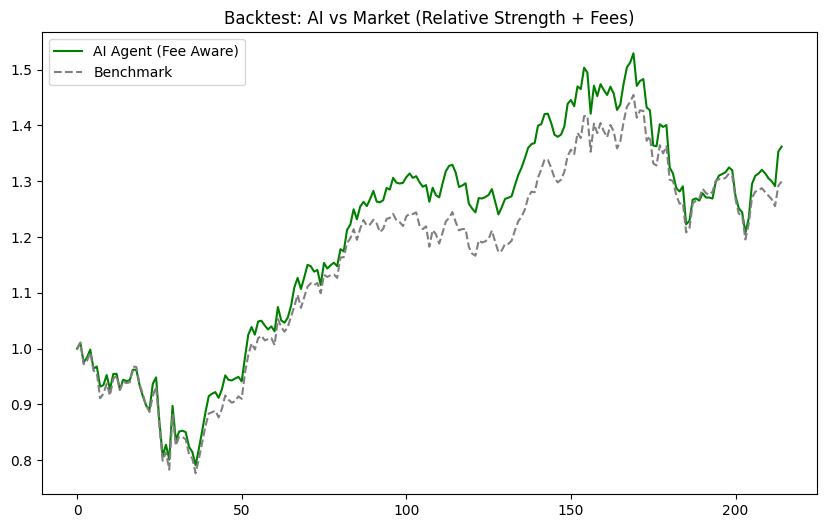

------------------------------------------------
  📊 FINAL BACKTEST REPORT  
------------------------------------------------
AI Total Return:      +36.21%
Benchmark Return:     +29.96%
------------------------------------------------
 AI BEAT MARKET BY:  +6.26%
------------------------------------------------


In [79]:
# 1. Setup Test Data
test_data = log_returns.iloc[split_idx:]
test_rsi = rsi_data.iloc[split_idx:]
test_excess = excess_data.iloc[split_idx:] # <--- NEW

print(f"Backtesting on {len(test_data)} days...")

# 2. Test Env
# We use the FULL realistic trading cost (0.001) here
test_env = PortfolioEnv(test_data, test_rsi, test_excess, trading_cost=0.001)
obs, _ = test_env.reset()
done = False

rl_vals = [1.0]
bench_vals = [1.0]

while not done:
    action, _ = model.predict(obs)
    
    current_idx = test_env.current_step
    if current_idx >= len(test_data): break
    
    # Bench
    bench_ret = np.mean(test_data.iloc[current_idx].values)
    bench_vals.append(bench_vals[-1] * (1 + bench_ret))
    
    # AI Net Return
    obs, reward, done, _, _ = test_env.step(action)
    ai_weights = test_env.softmax(action)
    
    # Manual Cost Calc for Chart
    gross_ret = np.sum(ai_weights * test_data.iloc[current_idx].values)
    
    # Estimate turnover cost (assuming standard rebalancing)
    # We subtract the full 0.1% fee to be honest in the chart
    current_turnover = np.sum(np.abs(ai_weights - obs['weights'])) 
    net_ret = gross_ret - (current_turnover * 0.001)
    
    rl_vals.append(rl_vals[-1] * (1 + net_ret))

plt.figure(figsize=(10, 6))
plt.plot(rl_vals, label='AI Agent (Fee Aware)', color='green')
plt.plot(bench_vals, label='Benchmark', color='gray', linestyle='--')
plt.title('Backtest: AI vs Market (Relative Strength + Fees)')
plt.legend()
plt.show()

ai_total_return = (rl_vals[-1] - 1) * 100
bench_total_return = (bench_vals[-1] - 1) * 100
outperformance = ai_total_return - bench_total_return

print("------------------------------------------------")
print(f"  📊 FINAL BACKTEST REPORT  ")
print("------------------------------------------------")
print(f"AI Total Return:      {ai_total_return:+.2f}%")
print(f"Benchmark Return:     {bench_total_return:+.2f}%")
print("------------------------------------------------")
if outperformance > 0:
    print(f" AI BEAT MARKET BY:  {outperformance:+.2f}%")
else:
    print(f" AI TRAILED MARKET:  {outperformance:+.2f}%")
print("------------------------------------------------")

In [73]:
# --- USER INPUT ---
my_portfolio = {
    'AAPL': 0.0,
    'NVDA': 0.0, 
    # Add others here. Unlisted = 0.0
}
# ------------------

current_weights_array = np.zeros(len(tickers))
for i, ticker in enumerate(tickers):
    if ticker in my_portfolio:
        current_weights_array[i] = my_portfolio[ticker]

# Normalize to 1.0
if np.sum(current_weights_array) > 0:
    current_weights_array /= np.sum(current_weights_array)
else:
    current_weights_array = np.ones(len(tickers)) / len(tickers)

print("Current Weights Normalized:", current_weights_array)

Current Weights Normalized: [0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353]


   Ticker  Current %  Target %  Action
15    VOO       5.88     15.03    9.15
3    AMZN       5.88     15.03    9.15
14    TSM       5.88     15.03    9.15
4    BBAI       5.88     10.23    4.35
10   NVDA       5.88     10.21    4.33
13   SOFI       5.88      7.39    1.51
6   GOOGL       5.88      6.65    0.77
9      MU       5.88      2.11   -3.78
0    AAPL       5.88      2.03   -3.85
11    NVO       5.88      2.03   -3.85
12   SMCI       5.88      2.03   -3.85
8    MSFT       5.88      2.03   -3.85
1    AIPO       5.88      2.03   -3.85
7    META       5.88      2.03   -3.85
5    CRWV       5.88      2.03   -3.85
2     AMD       5.88      2.03   -3.85
16     ZS       5.88      2.03   -3.85


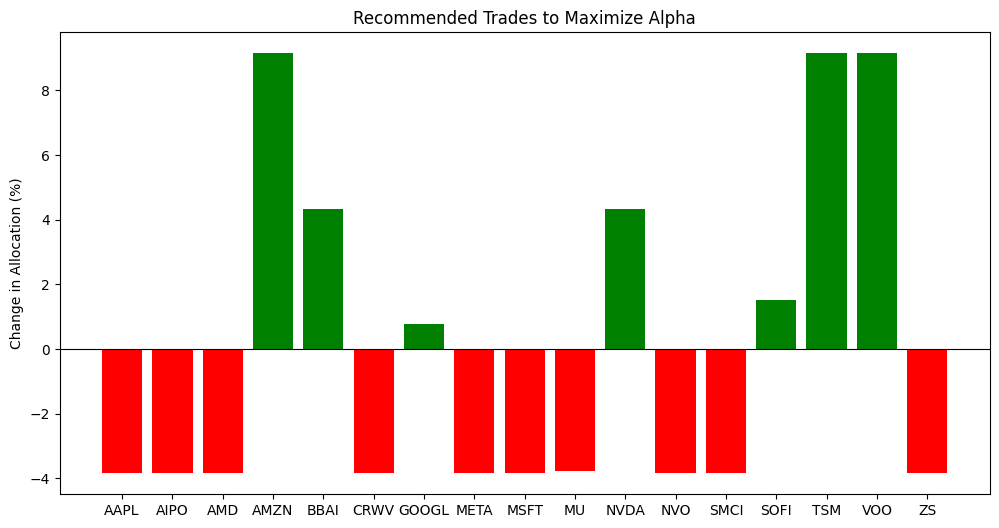

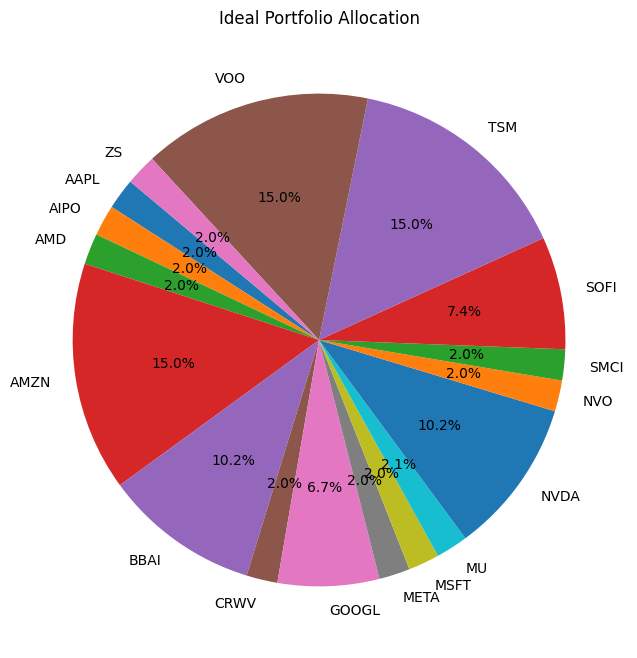

In [75]:
# 1. Get Last 30 Days of Data
last_30_ret = log_returns.iloc[-30:].values
last_30_rsi = rsi_data.iloc[-30:].values
last_30_excess = excess_data.iloc[-30:].values # <--- NEW

# 2. Create Observation
obs = {
    "returns": last_30_ret.reshape(1, 30, len(tickers)),
    "rsi": last_30_rsi.reshape(1, 30, len(tickers)),
    "excess": last_30_excess.reshape(1, 30, len(tickers)), # <--- NEW
    "weights": current_weights_array.reshape(1, len(tickers))
}

# 3. Predict
action, _ = model.predict(obs)

# 4. Decode
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

target_weights = softmax(action[0])

# 5. Show Plan
df_plan = pd.DataFrame({
    'Ticker': tickers,
    'Current %': current_weights_array * 100,
    'Target %': target_weights * 100,
    'Action': (target_weights - current_weights_array) * 100
})

# Filter for meaningful trades (> 0.5% change)
trades = df_plan[np.abs(df_plan['Action']) > 0.5].sort_values(by='Target %', ascending=False)

print(trades.round(2))

# 6. Visualization
plt.figure(figsize=(12, 6))
plt.bar(df_plan['Ticker'], df_plan['Action'], color=['g' if x>0 else 'r' for x in df_plan['Action']])
plt.title("Recommended Trades to Maximize Alpha")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Change in Allocation (%)")
plt.show()

# 7. The Shopping List (Pie Chart)
pie_data = df_plan[df_plan['Target %'] > 1.0]
plt.figure(figsize=(8, 8))
plt.pie(pie_data['Target %'], labels=pie_data['Ticker'], autopct='%1.1f%%', startangle=140)
plt.title("Ideal Portfolio Allocation")
plt.show()